# Práctica 3. Detección de formas

Práctica realizada por: Alejandro Rodríguez Moreno y Nauzet Déniz Perdomo

In [36]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt

TAREA: Captura una o varias imágenes con monedas no solapadas y algún objeto que no lo sea. Filtra los contornos que no se correpondan con monedas, y muestra el número total de monedas presentes en la imagen.

Una alternativa consiste en contar círculos utilizando la Transformada de Hough. La selección de parámetros puede ser "divertida", más [información](https://docs.opencv.org/4.x/da/d53/tutorial_py_houghcircles.html)

In [37]:
#Carga imagen ejemplo con monedas
img = cv2.imread('Monedas 1.jpeg') 
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


img2 = cv2.imread('Monedas 2.jpeg') 
img_rgb2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


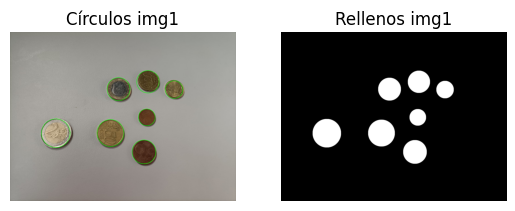

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


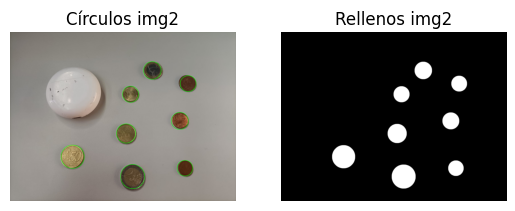

In [38]:
#Conversión a gris
gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gris2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

#Suaviza altas frecuencias
pimg = cv2.medianBlur(gris, 7)
pimg2 = cv2.medianBlur(gris2, 7)

#Localiza Círculos
circ = cv2.HoughCircles(
        pimg,  # imagen 
        cv2.HOUGH_GRADIENT,  # tipo de detección
        1,
        100,  # distancia mínima entre círculos
        param1=70, # Valor del gradiente
        param2=50, #Umbral acumulador
        minRadius=50,  # radio mínimo
        maxRadius=150,  # radio máximo
    )

#Localiza Círculos
circ2 = cv2.HoughCircles(
        pimg2,  # imagen 
        cv2.HOUGH_GRADIENT,  # tipo de detección
        1,
        100,  # distancia mínima entre círculos
        param1=70, # Valor del gradiente
        param2=50, #Umbral acumulador
        minRadius=40,  # radio mínimo
        maxRadius=150,  # radio máximo
    )

#Dibuja sobre entrada  e imagen vacía
img_cont = np.zeros(img_rgb.shape)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
for det in circ[0]:
        x_coor, y_coor, det_radio = det
        cv2.circle(img_rgb,(int(x_coor), int(y_coor)),
            int(det_radio),(0, 255, 0), 2)
        cv2.circle(img_cont,(int(x_coor), int(y_coor)),
            int(det_radio),(255, 255, 255), -1)
        
#Dibuja sobre entrada  e imagen vacía
img_cont2 = np.zeros(img_rgb2.shape)
img_rgb2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
for det2 in circ2[0]:
        x_coor2, y_coor2, det_radio2 = det2
        cv2.circle(img_rgb2,(int(x_coor2), int(y_coor2)),
            int(det_radio2),(0, 255, 0), 2)
        cv2.circle(img_cont2,(int(x_coor2), int(y_coor2)),
            int(det_radio2),(255, 255, 255), -1)

#Muestra resultado
plt.subplot(121)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Círculos img1')

plt.subplot(122)
plt.axis("off")
plt.imshow(img_cont) 
plt.title('Rellenos img1')

plt.show()

#Muestra resultado
plt.subplot(121)
plt.axis("off")
plt.imshow(img_rgb2) 
plt.title('Círculos img2')

plt.subplot(122)
plt.axis("off")
plt.imshow(img_cont2) 
plt.title('Rellenos img2')

plt.show()

TAREA: Captura una o varias imágenes con monedas no solapadas, y otras con monedas solapadas. Identificada una moneda de un euro en la imagen, por ejemplo con un clic de ratón, calcular la cantidad de dinero presente en la imagen. ¿Qué problemas han observado?


TAREA: Estas tres imágenes han sido extraidas de las imágenes de mayor tamaño contenidas en la carpeta. Determina patrones geométricos para cada una de las tres clases y evalúa los aciertos y fallos con las imágenes completas la matriz de confusión. Para cada clase, determina el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifica incorrectamente por cada una de las otras dos clases.

El el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas en dicho trabajo fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación del cuadrado del perímetro con el área)
- Relación del área con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

Si no se quedan satisfechos con la segmentación obtenida, es el mundo real, también en el README comento técnicas recientes de segmentación, que podrían despertar su curiosidad.

Las métricas se utilizan para mostrar la bondad de un clasificador, la siguiente celda obtiene varias para un conjunto de datos imaginario (y con etiquetas aleatorias). Si bien las trataremos con más detalle en teoría, muestro un repertorio de ellas, dando más peso a la matriz de confusión.

¿Qué es una matriz de confusión?
Se utiliza para mostrar el comportamiento de un clasificador par alas distintas clases consideradas, se relacionan las etiquetas de las muestras anotadas frente a las predichas por el clasificador. Se busca una matriz diagonal, pero la perfección es infrecuente